In [ ]:
#| default_exp learner

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *

from fastprogress import progress_bar,master_bar

In [ ]:
import torchvision.transforms.functional as TF
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Learner

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
bs = 1024
tds = dsd.with_transform(transformi)

In [ ]:
#|export
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True):
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds)) for ds in dd.values()])

In [ ]:
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [ ]:
#|export
def to_cuda(x):
    if isinstance(x, Mapping): return {k:v.cuda() for k,v in x.items()}
    return type(x)(o.cuda() for o in x)

In [ ]:
#|export
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_cuda(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
    
    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        model.cuda()
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            self.one_epoch(False)

In [ ]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.185219140625 0.59565
0 False 1.1349696428571427 0.6088142857142858


## Metrics

In [ ]:
#|export
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.forward(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    def __call__(self, inps=None, targs=None):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def forward(self, inps, targs): raise NotImplementedError()

In [ ]:
#|export
class Accuracy(Metric):
    def forward(self, inps, targs): return (inps==targs).float().mean()

In [ ]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc()

tensor(0.45)

In [ ]:
#|export
class Loss(Metric):
    def forward(self, inps, targs): return inps

In [ ]:
loss = Loss()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss(), round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

## Callbacks learner

In [ ]:
#|export
def identity(*args):
    if not args: return
    x,*args = args
    return (x,)+args if args else x

In [ ]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [ ]:
#|export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
        return _f

In [ ]:
#|export
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
        for cb in cbs: cb.learn = self

    @with_cbs('batch')
    def one_batch(self):
        self.predict()
        self.get_loss()
        if self.model.training:
            self.backward()
            self.step()
            self.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        self._one_epoch()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self.one_batch()
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self._fit()

    @with_cbs('fit')
    def _fit(self):
        for self.epoch in self.epochs:
            self.one_epoch(True)
            self.one_epoch(False)
        
    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm):
        for cb in sorted(self.cbs, key=attrgetter('order')): getattr(cb, method_nm,identity)()

In [ ]:
#|export
class Callback(): order = 0

In [ ]:
#|export
class TrainCB(Callback):
    def predict(self): self.learn.preds = self.learn.model(self.learn.batch[0])
    def get_loss(self): self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])
    def backward(self): self.learn.loss.backward()
    def step(self): self.learn.opt.step()
    def zero_grad(self): self.learn.opt.zero_grad()

In [ ]:
#|export
class CudaCB(Callback):
    def before_fit(self): self.learn.model.cuda()
    def before_batch(self): self.learn.batch = to_cuda(self.learn.batch)

In [ ]:
#|export
class MetricsCB(Callback):
    def __init__(self, metric=None):
        self.loss_m = Loss()
        self.all = [self.loss_m]
        if metric:
            self.metric = metric
            self.all.append(metric)

    def log(self, *s): print(self.learn.epoch, self.learn.model.training, *s)
    def before_fit(self): self.learn.metrics = self

    def before_epoch(self): [o.reset() for o in self.all]
    def after_epoch(self): self.log(*[f'{o():.3f}' for o in self.all])

    def after_batch(self):
        if hasattr(self, 'metric'):
            self.metric.add(self.learn.preds.argmax(dim=1), self.learn.batch[1])
        self.loss_m.add(self.learn.loss, n=len(self.learn.batch[0]))

In [ ]:
#|export
class ProgressCB(Callback):
    order=MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self):
        self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
        if hasattr(self.learn, 'metrics'): self.learn.metrics.log = self._log
        self.losses = []
    def _log(self, *s): self.mbar.write(' :: '.join(s))
    def before_epoch(self): self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.mbar)
    def after_batch(self):
        self.learn.dl.comment = f'{self.learn.loss:.3f}'
        if self.plot and hasattr(self.learn, 'metrics') and self.learn.model.training:
            self.losses.append(self.learn.metrics.loss_m.last.item())
            self.mbar.update_graph([[list(range(len(self.losses))), self.losses]])

In [ ]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

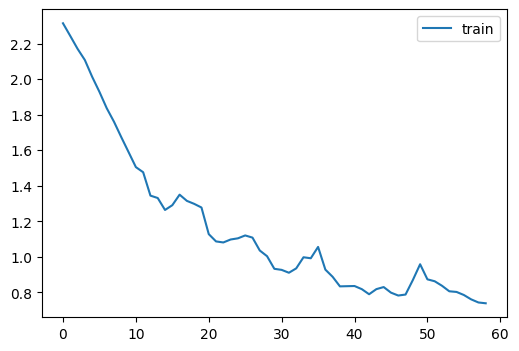

In [ ]:
cbs = [TrainCB(), CudaCB(), MetricsCB(Accuracy()), ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

### TrainingLearner subclass

In [ ]:
#|export
class MomentumLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= 0.85

In [ ]:
# NB: No TrainCB
cbs = [CudaCB(), MetricsCB(Accuracy()), ProgressCB()]
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()